# Hands-on Neural Network for Classifying Handwritten Digits

The data set we will be using is called [MNIST](http://yann.lecun.com/exdb/mnist/). It was create by Yann Lecun and is considered to be the "hello world" of datasets for deep learning. 

MNIST consists of 28x28 pixel images of hand written digis.

<center> <img src="img/mnist.png" width="300"/>  </center>

<br/>

We are going to create a feed forward neural network to classify the digits. This will be a simple network composed of linear layers and activations.

In [2]:
import torch
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

import time

## Create Transforms

When we get the dataset, we will be given tuples that look like:

        (PIL image, label)

We will need to apply a transform to each image loaded to convert it to a tensor. This can be done using a library included with Pytorch called TorchVision. This library contains datasets, helper functions, transforms, and even whole neural networks that can all be loaded easily.

We will use the transform `ToTensor()` which will convert each image to a tensor that we can use in our model. There are lots of other transforms that we have access to such as rotating or flipping images.

The `Compose` method is how you string several transforms together. They will be executed in the order they are put in the list.

In [3]:
xforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])  # Try with no normalization for now

Torchvision has several datasets builtin. These functions make it easy to download and create a dataset from these commonly used datasets.

In [4]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=xforms)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=xforms)

Now that the datasets are created we use them to instantiate the dataloader. A dataloader is a feature of pytorch that allows you to easily batch and loop over datasets. These can be cusomized by simply writing your own dataset class and feeding it to the dataloader. 

Dataloaders allow you to control the batch size, number of threads for loading, shuffling, collating and more.

In [5]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True)

## Lets take a look at the data

Pytorch data loaders are a convenient way to get tensors into your model with very little manual work. Custom datasets are very easy to define if you are using data that doesnt fit well into one of the predefined classes.

The dataloaders defined above work just like an iterator. We can get an item from it by calling `next(iter(loader))`. When accessing all of the data we simply have to loop over the dataloader `for data, label in dataloader:`.

Lets take a look at how the dataloader returns data to us. For the MNIST dataset (and most imagery data) it returns a tuple where the first element is a  tensor with the shape [batch, channels, height, width], and the second element is the label (in this case an integer).

In [9]:
d = next(iter(train_loader))
print(d[0].shape) # the data
print(d[1].shape) # the labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [10]:
d[1]

tensor([4, 3, 8, 4, 1, 4, 0, 5, 3, 1, 8, 4, 4, 1, 3, 8, 0, 6, 4, 5, 7, 7, 7, 9,
        3, 9, 8, 9, 9, 0, 5, 8, 3, 1, 6, 0, 4, 4, 8, 8, 0, 1, 0, 1, 8, 1, 6, 8,
        8, 9, 5, 3, 0, 3, 7, 4, 1, 2, 1, 2, 4, 7, 3, 5])

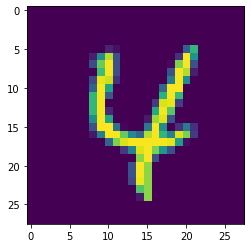

In [11]:
plt.imshow(d[0][0].squeeze().numpy())

## Defining our Classification Model

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layers = torch.nn.Sequential(
                            torch.nn.Linear(in_features=784, out_features=128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=128, out_features=64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=64, out_features=10),
                            torch.nn.Softmax(dim=1)
                        )
    
    def forward(self, x):
        return self.layers(x)

## Quiz

 1. Why is the input size 784?
 2. Why is the output size 10?
 3. Why are we using Softmax on the last layer instead of ReLU?

In [13]:
model = Net().to_device('cuda:0')

## Setup the Optimizer

We will be using the Adam optimizer.

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

## Setup the Loss function

For classification problems in general you will use the cross entropy loss.

In [15]:
criterion = torch.nn.CrossEntropyLoss()

## Run the training loop

In [16]:
epochs = 15
loss_history = []
for epoch in range(loaded_epoch, epochs):
    epoch_loss = 0
    epoch_time = time.time()
    for data, labels in train_loader:
        # Flatten the tensors to go from 28x28 -> 784
        flat_data = data.view(data.shape[0], -1).to_device(device)
        
        optimizer.zero_grad()
        pred = model(flat_data)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss/len(train_loader))    
    print(f"Epoch {epoch} | {time.time()-epoch_time:.2f} s - loss: {epoch_loss/len(train_loader)}")

Epoch 0 | 6.90 s - loss: 1.5983443323737268
Epoch 1 | 7.20 s - loss: 1.5141877420167171
Epoch 2 | 7.30 s - loss: 1.5050633366682382
Epoch 3 | 7.37 s - loss: 1.498974173435016
Epoch 4 | 7.61 s - loss: 1.4974307021352529
Epoch 5 | 7.76 s - loss: 1.4943976650105866
Epoch 6 | 7.82 s - loss: 1.4942159629833978
Epoch 7 | 8.05 s - loss: 1.4927045101804266
Epoch 8 | 8.09 s - loss: 1.4904928813611011
Epoch 9 | 8.17 s - loss: 1.490079967833277
Epoch 10 | 8.19 s - loss: 1.491015525769069
Epoch 11 | 8.23 s - loss: 1.4939467125355816
Epoch 12 | 8.24 s - loss: 1.490795740567799
Epoch 13 | 8.23 s - loss: 1.4896018459344469
Epoch 14 | 8.21 s - loss: 1.4892251004796546


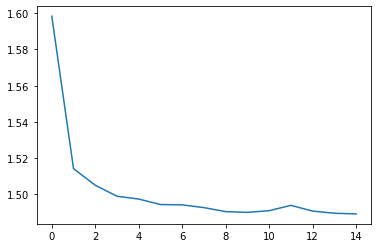

In [17]:
plt.plot(loss_history)

In [18]:
correct_count = 0
model.eval()
with torch.no_grad():
    for data, label in test_loader:
        flat_data = data.view(data.shape[0], -1)
        output = model(flat_data)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct_count += pred.eq(label.view_as(pred)).sum().item()
        
print(f"Correct/Total: {correct_count}/{len(test_loader.dataset)}")
print(f"Accuracy: {correct_count/len(test_loader.dataset):.4f}")

Correct/Total: 9639/10000
Accuracy: 0.9639


In [ ]:
torch.save({"model": model.state_dict(), 
            "optimizer": optimizer.state_dict(),
            "epoch": epoch})

In [ ]:
weights = torch.load(path)
model.load_state_dict(weights['model'])

## Untrained Model

Lets take a look at how the model does if we dont train it. Lets create a new model and run it on the validation set.

### BEFORE YOU RUN

### What do you expect the accuracy of the model to be?
Hint: How many classes are there? 

In [20]:
untrained = Net()

In [21]:
correct_count = 0
untrained.eval()
with torch.no_grad():
    for data, label in test_loader:
        flat_data = data.view(data.shape[0], -1)
        output = untrained(flat_data)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct_count += pred.eq(label.view_as(pred)).sum().item()
        
print(f"Correct/Total: {correct_count}/{len(test_loader.dataset)}")
print(f"Accuracy: {correct_count/len(test_loader.dataset):.4f}")

Correct/Total: 1211/10000
Accuracy: 0.1211
